# `hera_pspec` 5/16/2018 Design Review Warmup (edited)

HERA Power Spectrum Team
<br>
5/9/2018

In order to facilitate a productive meeting, we want participants to have a basic familiarity with the software development in `hera_pspec`. To this end, we ask that you spend some time looking over the example problems provided below. In looking over these problems, you may find it helpful to read [our documentation](http://hera-pspec.readthedocs.io/en/latest/) and/or to look over our [tutorial notebooks](https://github.com/HERA-Team/hera_pspec/tree/master/examples).

This notebook requires that you have installed the most up-to-date version of `hera_pspec`. See [our README](https://github.com/HERA-Team/hera_pspec) for installation instructions and dependencies.

### Do this

In [1]:
%matplotlib inline
import hera_pspec as hp
import matplotlib.pyplot as plt
import numpy as np
# from hera_pspec.data import DATA_PATH
from pyuvdata import UVData
# import os
# import glob
import uvtools

## Task 1: Push data through to a basic delay spectra 

This task is to designed to simulate a basic power spectrum pipeline, from calibrated data to delay spectra in cosmological units.

### 1a: Load the data
Start by loading in calibrated, RFI flagged and LST-binned visibility test data, `zen.all.xx.LST.1.06964.uvA`, into a `pyuvdata.UVData` object. This data can be accessed by constructing the path `os.path.join(DATA_PATH, <filename>)`.

In [23]:
# select the data file to load
# dfile = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')
dfile = 'data/zen.all.xx.LST.1.06964.uvA'
# dfile = 'data/zen.odd.std.xx.LST.1.28828.uvOCRSA'
# Load into UVData objects
uvd = UVData()
uvd.read_miriad(dfile)

# Check which baselines are available
print(uvd.get_antpairs())
print(uvd.get_ants())
print(uvd.Nbls)
print(uvd.data_array.shape)


[(24, 24), (24, 25), (24, 37), (24, 38), (24, 39), (25, 25), (25, 37), (25, 38), (25, 39), (37, 37), (37, 38), (37, 39), (38, 38), (38, 39), (39, 39)]
[24 25 37 38 39]
15
(90, 1, 1024, 1)


In [3]:
def waterfall(
    vis, freq=uvd.freq_array[0]/1e6, lsts=uvd.lst_array, 
    vmax=None, vrange=None, title=None,
):
    """
    A wrapper around the uvtools' waterfall function providing some
    extra labelling and plot adjustment.
    """
    fig, ax = plt.subplots(
        2,1, sharex=True, sharey=True, figsize=(12,10)
    )
    
    if title is not None:
        ax[0].set_title(title, fontsize=12)
    plt.sca(ax[0])
    uvtools.plot.waterfall(
        vis[:,0,:,0], mode='log', mx=vmax, drng=vrange,
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label=r'log$_{10}$(Vis/Jy)')
    plt.ylabel("LST", fontsize=12)
    
    plt.sca(ax[1])
    uvtools.plot.waterfall(
        vis[:,0,:,0], 
        mode='phs',
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label='Phase [rad]')
    plt.xlabel("Frequency [MHz]", fontsize=12)
    plt.ylabel("LST", fontsize=12)

In [4]:
print(uvd.data_array.shape)
# print(uvd.data_array)

(90, 1, 1024, 1)


divide by zero encountered in log10


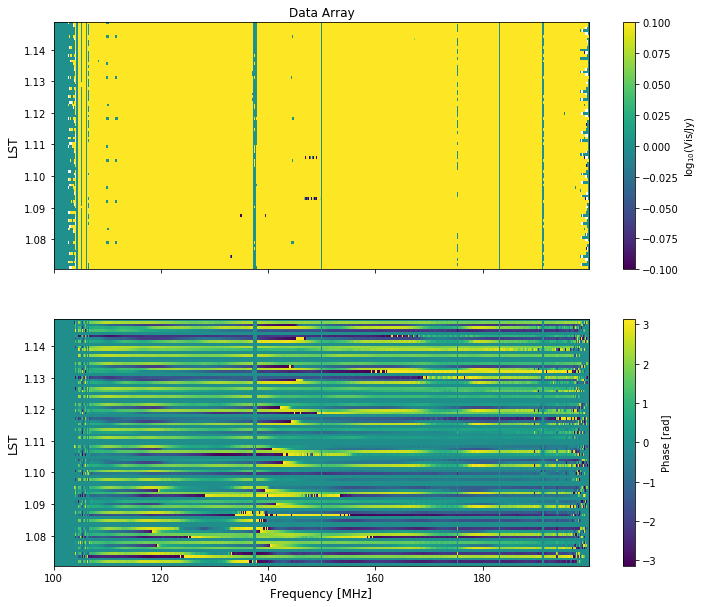

In [5]:
waterfall(uvd.data_array, title='Data Array')

### 1b: Define the cosmological model
Next define the cosmological model you will use in this notebook by instantiating a `hera_pspec.conversions.Cosmo_Conversions()`.

In [10]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()

### 1c: Choose a beam model
Use the `HERA_NF_dipole_power.beamfits` file in the `DATA_PATH` for the beam model. You can load this in using the `hera_pspec.pspecbeam.PSpecBeamUV` object. *Don't forget to pass the cosmology object you instantiated previously through to the beam via the *`cosmo`* keyword-argument.*

In [12]:
# List of beamfile to load.
beamfile = 'data/HERA_NF_dipole_power.beamfits'

# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

### 1d: Jy to mK conversion

Use the beam object you instantiated to convert the units of the data in the `UVData` object from Janskies to milli-Kelvin. Don't forget to change the `vis_units` attribute of the `UVData` object to `mK`.

In [8]:
# find conversion factor from Jy to mK
# Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
# uvd.data_array *= Jy_to_mK[None, None, :, None]

### 1e: Create a `PSpecData` object and run OQE

Instantiate a `PSpecData` object, feeding the single `UVData` object as both the first and second dataset, and pass the beam model through via the `beam` keyword. Then run OQE to generate power spectra between baselines `(24, 25) & (37, 38)` with identity data weighting and `I` normalization. Choose a spectral window between channels 600 -- 700.

In [20]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, feeding the single UVData object as both the first and second dataset
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

(45, 1, 1024, 1)


In [15]:
# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)
# change units of UVData objects
# ds.dsets[0].vis_units = 'mK'
# ds.dsets[1].vis_units = 'mK'

In [16]:
# Specify which baselines to include
# baselines = [(24,25), (37,38)]
baselines = [(24,25)]

In [17]:
# we will use the baselines list to produce power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across spectral window between channels 600 -- 700 with identity weighting and a blackman-harris taper
uvp = ds.pspec(baselines, baselines, (0, 0), [('xx', 'xx')], spw_ranges=[(600, 700)], 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (600, 700)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


### 1f: Plot the power spectra

Simple enough. (See `hera_pspec.plot` module for a plotting interface).

Text(0.5, 1.0, 'spw : 0, blpair : ((24, 25), (24, 25)), pol : xx')

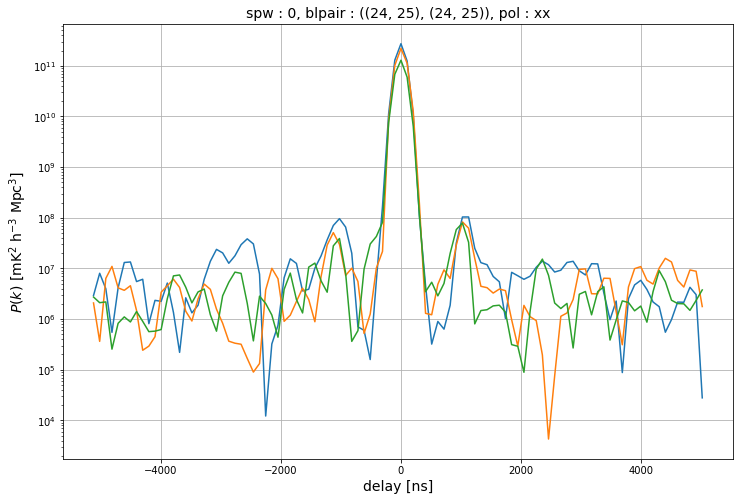

In [18]:
# (bl1, bl2) pair: ((24, 25), (24, 25))
# plot power spectrum of spectral window 0
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp =((24, 25), (24, 25))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)


AssertionError: blpair 137138137138 not found in data, blpairs are: [124125124125 124125124125 124125124125]

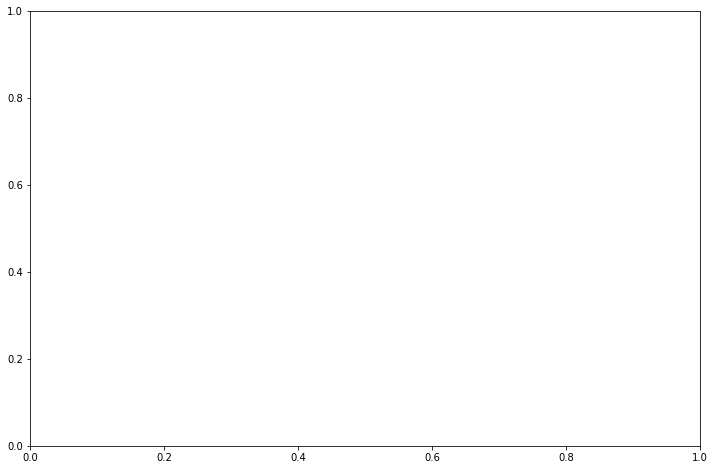

In [19]:
#(bl1, bl2) pair: ((37, 38), (37, 38))
# plot power spectrum of spectral window 0
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp =((37,38), (37,38))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

In [21]:
## Doubts: What is Spectral window 0,1 ?


### Bonus:

### 1g: Run OQE on a set of redundant baselines

Now generate multiple delay spectra by cross-multiplying baselines within a redundant group. To start, you may want to look at the `hera_pspec.pspecdata.construct_blpairs` function.

In [22]:
# baselines is a redundant baseline group
baselines = [(24,25), (37,38)]

# calculate all baseline pairs from group
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, exclude_auto_bls=True, 
                                                                 exclude_permutations=True)

# Inspect baseline pairs
print(blpairs)

[((24, 25), (37, 38))]


### 1h: Generate thermal noise estimates and add them to the plot
We will soon have system temperature measurements from the LSTbinned data, but for now just assume $T_{\rm sys} = 300\rm\ K$.

### 1i: Generate bootstrap error bars and add them to the plot